<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Desarrollo

Para el conjunto de datos se optó por usar poemas del artista chileno Pablo Neruda, ya que sus poemas tienen una estructura clara y regular que puede a dar resultados muy interesantes para este trabajo practico.

Los poemas fueron recuperados de los siguientes sitios web y adjuntos a unos archivos de texto plano:

* [Veinte poemas de amor y una canción desesperada](https://www.archivochile.com/Homenajes/neruda/de_neruda/homenajepneruda0007.pdf)
* [Crepusculario](https://ia601405.us.archive.org/9/items/crepusculario00neru/crepusculario00neru.pdf)

In [3]:
!pip install -q gradio

In [4]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2025-08-07 00:02:15.353169: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 00:02:15.434170: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 00:02:15.494711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754542935.567266 1222341 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754542935.585753 1222341 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754542935.738854 1222341 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Datos
Se empleará un corpus compuesto por poemas de Pablo Neruda.

In [10]:
def abrir_archivo(file_path):
    """
      Abre un archivo de texto en la ruta especificada y retorna su contenido como una cadena.

      Parameters:
          file_path (str): Ruta del archivo a abrir.

      Returns:
          str: Contenido completo del archivo como una cadena de texto.

      Raises:
          FileNotFoundError: Si el archivo no se encuentra en la ruta especificada.
          Exception: Si ocurre un error diferente al intentar leer el archivo.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
          return f.read()
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: El archivo no se encontraba en al ruta {file_path}")
    except Exception as e:
        raise Exception(f"Ocurrió un error: {e}")


def limpieza_texto(texto):
    """
      Realiza una limpieza básica del texto eliminando saltos de línea, tabulaciones,
      caracteres especiales y normalizando acentos. Convierte todo el texto a minúsculas.

      Parameters:
          texto (str): Texto original a limpiar.

      Returns:
          str: Texto limpio y normalizado.
    """
    texto = texto.lower()
    texto = texto.replace('\n', ' ')
    texto = texto.replace('\t', ' ')
    texto = texto.replace('\r', ' ')
    texto = texto.replace('á', 'a')
    texto = texto.replace('é', 'e')
    texto = texto.replace('í', 'i')
    texto = texto.replace('ó', 'o')
    texto = texto.replace('ú', 'u')

    return texto


In [6]:
!pip install gdown


In [14]:
#En caso de no disponer de los archivos usar esta celda para descargarlos
!mkdir -p datos
# Enlace al archivo "Veinte poemas de amor y una canción desesperada.txt" https://drive.google.com/file/d/1OWYk-KFYmVbU1bcjFfWIQQE3CW_bWUmk/view?usp=drive_link
file_id = "1OWYk-KFYmVbU1bcjFfWIQQE3CW_bWUmk"
!gdown --id {file_id} -O datos/veinte_poemas_de_amor_y_una_canción_desesperada.txt

# Enlace al archivo "crespusculario.txt" https://drive.google.com/file/d/1CifqQLnaIvaeg2XcBqeOPB3gQezMaBtJ/view?usp=drive_link
file_id = "1CifqQLnaIvaeg2XcBqeOPB3gQezMaBtJ"
!gdown --id {file_id} -O datos/crepusculario.txt



/home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/.venv/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OWYk-KFYmVbU1bcjFfWIQQE3CW_bWUmk
To: /home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/desafio_3/datos/veinte_poemas_de_amor_y_una_canción_desesperada.txt
100%|███████████████████████████████████████| 21.2k/21.2k [00:00<00:00, 565kB/s]
/home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/.venv/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading

In [15]:
# un poema de neruda
file_path_poema1 = "datos/veinte_poemas_de_amor_y_una_canción_desesperada.txt"
file_path_poema2 = "datos/crepusculario.txt"


poema_1 = abrir_archivo(file_path_poema1)
poema_2 = abrir_archivo(file_path_poema2)


poema_1 = limpieza_texto(poema_1)
poema_2 = limpieza_texto(poema_2)


corpus = ''
corpus += poema_1
corpus += ' '
corpus += poema_2
corpus

'cuerpo de mujer, blancas colinas, muslos blancos, te pareces al mundo en tu actitud de entrega. mi cuerpo de labriego salvaje te socava y hace saltar el hijo del fondo de la tierra. fui solo como un tunel. de mi huian los pajaros y en mi la noche entraba su invasion poderosa. para sobrevivirme te forje como un arma, como una flecha en mi arco, como una piedra en mi honda. pero cae la hora de la venganza, y te amo. cuerpo de piel, de musgo, de leche avida y firme. ah los vasos del pecho! ah los ojos de ausencia! ah las rosas del pubis! ah tu voz lenta y triste! cuerpo de mujer mia, persistira en tu gracia. mi sed, mi ansia sin limite, mi camino indeciso! oscuros cauces donde la sed eterna sigue, y la fatiga sigue, y el dolor infinito. en su llama mortal la luz te envuelve. absorta, palida doliente, asi situada contra las viejas helices del crepusculo que en torno a ti da vueltas. muda, mi amiga, sola en lo solitario de esta hora de muertes y llena de las vidas del fuego, pura heredera 

In [16]:
len(corpus)

53686

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [17]:
# seleccionamos el tamaño de contexto
max_context_size = 100

config = {'max_context_size': max_context_size}

In [18]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [19]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(corpus)

In [20]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

42

In [21]:
# Construimos los diccionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [22]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in corpus]

In [23]:
tokenized_text[:10]

[15, 35, 7, 26, 25, 22, 13, 39, 7, 13]

### Organizando y estructurando el dataset

In [24]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.2
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))
print(f" int(np.ceil({len(tokenized_text)}*{p_val}/{max_context_size}))")
num_val

 int(np.ceil(53686*0.2/100))


108

In [25]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [26]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [27]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [28]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [29]:
tokenized_sentences_val

[[],
 [22],
 [6, 20],
 [12, 17, 13],
 [22, 13, 6, 22],
 [22, 13, 7, 21, 13],
 [13, 27, 17, 39, 28, 13],
 [12, 17, 37, 12, 22, 37, 13],
 [7, 26, 13, 28, 21, 13, 38, 7],
 [27, 7, 37, 13, 39, 7, 13, 20, 35],
 [12, 7, 13, 21, 17, 12, 17, 20, 28, 6],
 [35, 7, 13, 25, 28, 37, 28, 13, 23, 13, 5],
 [13, 20, 35, 37, 13, 28, 6, 22, 37, 31, 13, 21],
 [22, 15, 28, 13, 32, 17, 6, 28, 31, 13, 28, 12, 28],
 [25, 28, 26, 28, 13, 7, 21, 13, 5, 35, 7, 13, 28, 12],
 [35, 13, 27, 17, 39, 28, 31, 13, 27, 17, 27, 7, 37, 13, 7],
 [37, 20, 7, 18, 28, 13, 39, 7, 21, 13, 15, 17, 7, 21, 22, 13],
 [7, 21, 13, 32, 22, 6, 39, 22, 13, 39, 7, 13, 35, 6, 13, 25, 28],
 [13, 37, 17, 6, 13, 12, 7, 39, 17, 20, 28, 26, 13, 7, 6, 13, 7, 21],
 [22, 13, 35, 6, 28, 13, 7, 37, 20, 26, 7, 21, 21, 28, 4, 19, 13, 37, 17],
 [22, 13, 1, 26, 17, 20, 28, 4, 13, 6, 22, 13, 3, 28, 23, 13, 22, 17, 39, 22],
 [11,
  13,
  37,
  7,
  13,
  12,
  35,
  7,
  26,
  7,
  13,
  7,
  21,
  13,
  35,
  6,
  17,
  27,
  7,
  26,
  37],
 [26,
  6,
 

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [30]:
X.shape

(42786, 100)

In [31]:
X[0,:10]

array([15, 35,  7, 26, 25, 22, 13, 39,  7, 13])

In [32]:
y[0,:10]

array([35,  7, 26, 25, 22, 13, 39,  7, 13, 12])

In [33]:
vocab_size = len(chars_vocab)

In [34]:
tokenized_sentences_train

[[15,
  35,
  7,
  26,
  25,
  22,
  13,
  39,
  7,
  13,
  12,
  35,
  36,
  7,
  26,
  31,
  13,
  38,
  21,
  28,
  6,
  15,
  28,
  37,
  13,
  15,
  22,
  21,
  17,
  6,
  28,
  37,
  31,
  13,
  12,
  35,
  37,
  21,
  22,
  37,
  13,
  38,
  21,
  28,
  6,
  15,
  22,
  37,
  31,
  13,
  20,
  7,
  13,
  25,
  28,
  26,
  7,
  15,
  7,
  37,
  13,
  28,
  21,
  13,
  12,
  35,
  6,
  39,
  22,
  13,
  7,
  6,
  13,
  20,
  35,
  13,
  28,
  15,
  20,
  17,
  20,
  35,
  39,
  13,
  39,
  7,
  13,
  7,
  6,
  20,
  26,
  7,
  1,
  28,
  4,
  13,
  12,
  17,
  13,
  15],
 [35,
  7,
  26,
  25,
  22,
  13,
  39,
  7,
  13,
  12,
  35,
  36,
  7,
  26,
  31,
  13,
  38,
  21,
  28,
  6,
  15,
  28,
  37,
  13,
  15,
  22,
  21,
  17,
  6,
  28,
  37,
  31,
  13,
  12,
  35,
  37,
  21,
  22,
  37,
  13,
  38,
  21,
  28,
  6,
  15,
  22,
  37,
  31,
  13,
  20,
  7,
  13,
  25,
  28,
  26,
  7,
  15,
  7,
  37,
  13,
  28,
  21,
  13,
  12,
  35,
  6,
  39,
  22,
  13,
  7,
  6,
  1

# Definiendo el modelo

In [35]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, Embedding, GRU, LSTM
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [36]:
rnn_model = Sequential()

rnn_model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
rnn_model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
rnn_model.add(Dense(vocab_size, activation='softmax'))
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

rnn_model.summary()

/home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
E0000 00:00:1754543281.605064 1222341 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754543281.609486 1222341 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 42)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        48,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 42)       │         8,442 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,042 (222.82 KB)

 Trainable params: 57,042 (222.82 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=256, input_shape=(max_context_size,)))
lstm_model.add(LSTM(300, return_sequences=True))
lstm_model.add(LSTM(150, return_sequences=True))
lstm_model.add(Dense(vocab_size, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

lstm_model.summary()

/home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 256)       │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 300)       │       668,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 150)       │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 42)        │         6,342 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 956,094 (3.65 MB)

 Trainable params: 956,094 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_context_size,)))
gru_model.add(GRU(200, return_sequences=True))
gru_model.add(Dense(vocab_size, activation='softmax'))

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 200)       │       198,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 42)        │         8,442 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,818 (827.41 KB)

 Trainable params: 211,818 (827.41 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo RNN


### Callback para entrenamientos


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [39]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5, model_name='my_model'):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.model_name = model_name

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"{self.model_name}.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [40]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = rnn_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name="modelos/simpleRNN_model")], batch_size=256)


Epoch 1/20


2025-08-07 00:08:01.985532: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34228800 exceeds 10% of free system memory.
2025-08-07 00:08:02.091474: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34228800 exceeds 10% of free system memory.


  1/168 ━━━━━━━━━━━━━━━━━━━━ 9:24 3s/step - loss: 3.7849

2025-08-07 00:08:05.413139: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of free system memory.
2025-08-07 00:08:05.418700: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of free system memory.
2025-08-07 00:08:05.446174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of free system memory.


167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.7501
 mean perplexity: 8.867981600311568 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - loss: 2.4977
Epoch 2/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2.1500
 mean perplexity: 7.858206904159402 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 2.1179
Epoch 3/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2.0508
 mean perplexity: 7.490562036352338 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 2.0335
Epoch 4/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.9852
 mean perplexity: 7.167383902477768 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 1.9704
Epoch 5/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.9291
 mean perplexity: 6.940848512469597 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 1.9143
Epoch 6/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.8738
 mean perplexity: 6.6583785

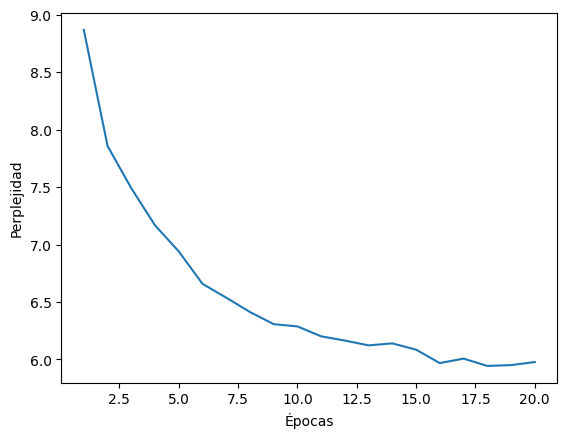

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.ylabel('Perplejidad')
plt.xlabel('Épocas')
plt.show()

In [43]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
RNN_model = keras.models.load_model('modelos/simpleRNN_model.keras')

### Entrenamiento del modelo LSTM

In [44]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = lstm_model.fit(X, y, epochs=30, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name="modelos/RNN_LSTM_model")], batch_size=256)


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.9635
 mean perplexity: 13.247672323910695 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - loss: 2.8303
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.4017
 mean perplexity: 9.35634407907162 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 2.3006
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.1341
 mean perplexity: 8.53359636270775 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - loss: 2.1000
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.0063
 mean perplexity: 7.833835336397279 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - loss: 1.9771
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.8921
 mean perplexity: 7.277423341319246 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - loss: 1.8653
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.7887
 mean perplexity: 7.250629877144435 

Saved n

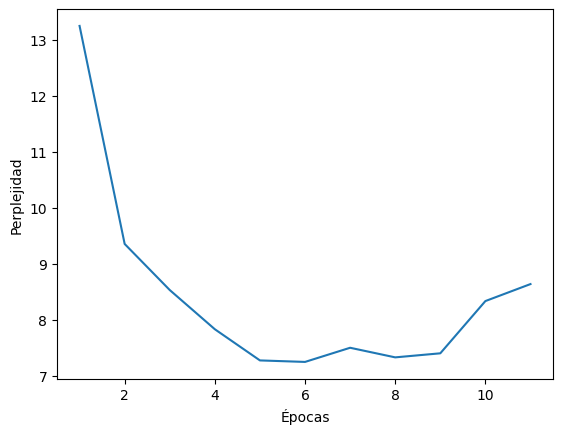

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.ylabel('Perplejidad')
plt.xlabel('Épocas')
plt.show()

In [46]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
LSTM_model = keras.models.load_model('modelos/RNN_LSTM_model.keras')

### Entrenamiento del modelo GRU

In [47]:
history_ppl = []
hist = rnn_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name="modelos/RNN_GRU_model", patience=10)], batch_size=256)

Epoch 1/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5454
 mean perplexity: 5.884668946266174 

Saved new model!
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - loss: 1.5443
Epoch 2/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5405
 mean perplexity: 5.9523948408522696 

168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - loss: 1.5376
Epoch 3/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5293
 mean perplexity: 6.048557695352806 

168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 1.5293
Epoch 4/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5256
 mean perplexity: 5.978636415499561 

168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 1.5238
Epoch 5/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5192
 mean perplexity: 5.966542536357664 

168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 1.5187
Epoch 6/20
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5122
 mean perplexity: 5.97021503493471 

168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - 

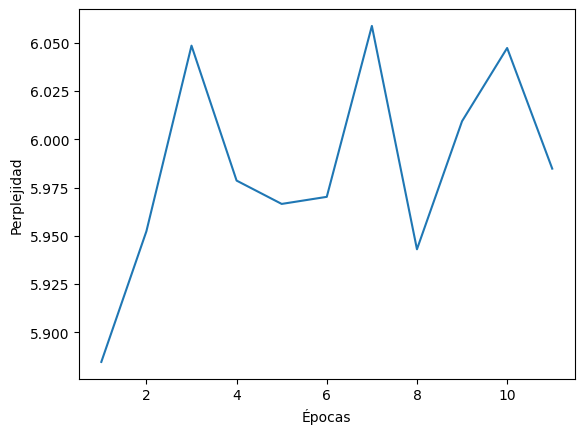

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.ylabel('Perplejidad')
plt.xlabel('Épocas')
plt.show()

In [49]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
GRU_model = keras.models.load_model('modelos/RNN_GRU_model.keras')


## Predicción del próximo caracter

In [50]:
# Predicción usando RNN
import gradio as gr

# Se modifico el método para que devuelva una mayor cantidad de caracteres.
def model_response(human_text):
    char_len = 25
    output_text = human_text

	  # generate a fixed number of characters
    for _ in range(char_len):
        # Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
        # Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

        # Predicción softmax
        y_hat = np.argmax(RNN_model.predict(encoded,verbose=0)[0,-1,:])

        # Vamos concatenando las predicciones
        out_word = ''
        out_word = idx2char[y_hat]

        # Agrego las palabras a la frase predicha
        output_text += out_word

    return output_text

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

/home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Análisis de secuencias con estategia greedy modelo RNN simple
A continuación se lista algunas subcadenas que se introdujeron y los resultados obtenidos:

**Cadenas Cortas**
* cierro : cierros de las callas de las ca
* mujer : mujer, y el viento la mis de l
* luz : luzas de las callas de las c
* oh : ohos de las callas de las c
* yo: yos de las callas de las ca

**Cadenas Largas**
* latiendo sobre nuestro silencio enamorado : latiendo sobre nuestro silencio enamorado en las redes de las call
* y abierta como una fruta : y abierta como una fruta de las callas de las cal
* Abeja blanca zumbas --ebria de miel en mi alma: Abeja blanca zumbas --ebria de miel en mi alma en tu alma de las callas
* el atlas blanco de tu cuerpo : el atlas blanco de tu cuerpo de las callas de las cal
* El viento. El viento. : El viento. El viento. el viento la mis de las 

**Cadenas nuevas**
* zapato : zapatos de las callas de las ca
* estroboscopico : estroboscopicos en la noche en la prier
* camino al sol : camino al sol destido en el agua de la
* ratoclos : ratoclos de las callas de las cal
* x : xilas en las redes de las 


### Conlusión 
El modelo alcanzó un valor menor a 7 de perplejidad. Se observa que intenta completar las subcadenas que le son ingresadas. Además presenta un sesgo con los terminos "de las calles".

In [ ]:
# Predicción usando RNN con LSTM
import gradio as gr

# Se modifico el método para que devuelva una mayor cantidad de caracteres.
def model_response_LSTM(human_text):
    char_len = 25
    output_text = human_text

	  # generate a fixed number of characters
    for _ in range(char_len):
        # Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
        # Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

        # Predicción softmax
        y_hat = np.argmax(lstm_model.predict(encoded,verbose=0)[0,-1,:])

        # Vamos concatenando las predicciones
        out_word = ''
        out_word = idx2char[y_hat]

        # Agrego las palabras a la frase predicha
        output_text += out_word

    return output_text

iface = gr.Interface(
    fn=model_response_LSTM,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0d61d2ab587549008d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Análisis de secuencias con estategia greedy modelo LSTM
A continuación se lista algunas subcadenas que se introdujeron y los resultados obtenidos:

**Cadenas Cortas**
* cierro : cierros de las calles de las ca
* mujer : mujera y me parece en la noche
* luz : luzas y en tu vida de amor d
* oh : oh que en la noche de las a
* yo: yos y estanas como esta en 

**Cadenas Largas**
* latiendo sobre nuestro silencio enamorado : latiendo sobre nuestro silencio enamorado a mi alma en el agua de 
* y abierta como una fruta : y abierta como una fruta de la noche en la noche 
* Abeja blanca zumbas --ebria de miel en mi alma: Abeja blanca zumbas --ebria de miel en mi alma en la noche de las alas 
* el atlas blanco de tu cuerpo : el atlas blanco de tu cuerpo de la noche en tus ojos 
* El viento. El viento. : El viento. El viento. el viento de la noche en

**Cadenas nuevas**
* zapato : zapatos que en la noche de las 
* estroboscopico : estroboscopicos, en la noche en las ala
* camino al sol : camino al soledad de tus ojos de la no
* ratoclos : ratoclos, en la noche en la noch
* x : xas huradas que en la noch


### Conlusión 
El modelo alcanzó un valor de perplejidad menor a 8. Se observa que el modelo agrega caracteres al final de cada la cadena de ingreso. Además que tiende a inventar ciertas palabras cuando se le introduce cadenas muy cortas. El modelo presenta buena coherencia con el uso de sustantivos acompañados de conectores.


In [ ]:
# Predicción usando RNN con GRU
import gradio as gr

# Se modifico el método para que devuelva una mayor cantidad de caracteres.
def model_response_GRU(human_text):
    char_len = 25
    output_text = human_text

	  # generate a fixed number of characters
    for _ in range(char_len):
        # Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
        # Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

        # Predicción softmax
        y_hat = np.argmax(GRU_model.predict(encoded,verbose=0)[0,-1,:])

        # Vamos concatenando las predicciones
        out_word = ''
        out_word = idx2char[y_hat]

        # Agrego las palabras a la frase predicha
        output_text += out_word

    return output_text

iface = gr.Interface(
    fn=model_response_GRU,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Análisis de secuencias con estategia greedy modelo GRU
A continuación se lista algunas subcadenas que se introdujeron y los resultados obtenidos:

**Cadenas Cortas**
* cierro : cierros y su voz de parece. se 
* mujer : mujer, y de sueño y estoy y la
* luz : luzando esta hora de la noch
* oh : ohos de la noche se dice en
* yo: yo la noche se dice en la n

**Cadenas Largas**
* latiendo sobre nuestro silencio enamorado : latiendo sobre nuestro silencio enamorado en la noche se dice en l
* y abierta como una fruta : y abierta como una fruta de la noche se dice en l
* Abeja blanca zumbas --ebria de miel en mi alma : Abeja blanca zumbas --ebria de miel en mi alma en la noche se dice en l
* el atlas blanco de tu cuerpo :  el atlas blanco de tu cuerpo de la noche se dice en l
* El viento. El viento. : El viento. El viento. el sol campo en la noche

**Cadenas nuevas**
* zapato : zapatos en la noche se dice en 
* estroboscopico : estroboscopicos en la noche se dice en 
* camino al sol : camino al sol descondio en la noche se
* ratoclos : ratoclos campos de la noche se di
* x : xiras. y la tierra de su c


### Conlusión 
El  modelo alcanzo un valor aproximado de 6.6 de perplejidad. Al igual que los otros modelos intenta completar la palabra ingresada, en este caso se observa un sesgo con la letra "s". Igual que los modelos anteriores también intenta inventar palabras cuando se le pasa una cadena muy corta


## Generación de secuencias

### Estrategia greedy

In [51]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax (gready)
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [52]:
input_text='iglesia' # texto extraido del conjunto de datos

print(f"Salida del modelo RNN con celdas de Elman: \n\t{generate_seq(RNN_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas LSTM: \n\t{generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas GRU: \n\t{generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30)}\n")

Salida del modelo RNN con celdas de Elman: 
	iglesia de las olas de las ristes est

Salida del modelo RNN con celdas LSTM: 
	iglesias como en la para de la vas al

Salida del modelo RNN con celdas GRU: 
	iglesia de la noche en el agua de la 



In [53]:
input_text='alegr' # texto incompleto extraido del conjunto de datos

print(f"Salida del modelo RNN con celdas de Elman: \n\t{generate_seq(RNN_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas LSTM: \n\t{generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas GRU: \n\t{generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30)}\n")

Salida del modelo RNN con celdas de Elman: 
	alegre de las olas de las ristes es

Salida del modelo RNN con celdas LSTM: 
	alegre en la viento en la viento en

Salida del modelo RNN con celdas GRU: 
	alegre de la noche en el agua de la



In [54]:
input_text='de la se de la' # subcadena que se identificó como repetitiva en el modelo RNN con celdas LSTM

print(f"Salida del modelo RNN con celdas de Elman: \n\t{generate_seq(RNN_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas LSTM: \n\t{generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas GRU: \n\t{generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30)}\n")

Salida del modelo RNN con celdas de Elman: 
	de la se de las estrellas en el agua de las 

Salida del modelo RNN con celdas LSTM: 
	de la se de la mariana de la vasa de la vasa

Salida del modelo RNN con celdas GRU: 
	de la se de la noche en el agua de la noche 



In [55]:
input_text='pies cansados de la noche' # texto nuevo

print(f"Salida del modelo RNN con celdas de Elman: \n\t{generate_seq(RNN_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas LSTM: \n\t{generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas GRU: \n\t{generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30)}\n")

Salida del modelo RNN con celdas de Elman: 
	pies cansados de la noche en el agua de las olas de las

Salida del modelo RNN con celdas LSTM: 
	pies cansados de la noche en la viento en la viento en 

Salida del modelo RNN con celdas GRU: 
	pies cansados de la noche en el agua de la noche en el 



In [56]:
input_text='coco' # texto nuevo 

print(f"Salida del modelo RNN con celdas de Elman: \n\t{generate_seq(RNN_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas LSTM: \n\t{generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas GRU: \n\t{generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30)}\n")

Salida del modelo RNN con celdas de Elman: 
	coco de las estrellas en el agua d

Salida del modelo RNN con celdas LSTM: 
	cocos en la viento en la viento en

Salida del modelo RNN con celdas GRU: 
	coco de la noche en el agua de la 



In [57]:
# texto extraido de crepusculario:
# Nunca dejemos de beber. Nunca dejemos de beber.
# Nunca, mujer, rayo de luz, pulpa blanca de poma,
# suavices la pisada que no te hara sufrir.
input_text='Nunca dejemos de beber.'

print(f"Salida del modelo RNN con celdas de Elman: \n\t{generate_seq(RNN_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas LSTM: \n\t{generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30)}\n")
print(f"Salida del modelo RNN con celdas GRU: \n\t{generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30)}\n")

Salida del modelo RNN con celdas de Elman: 
	Nunca dejemos de beber. pero de las olas de las riste

Salida del modelo RNN con celdas LSTM: 
	Nunca dejemos de beber. al viento en la viento en la 

Salida del modelo RNN con celdas GRU: 
	Nunca dejemos de beber. yo no se en el agua de la noc



### Análisis de secuencias con estategia greedy modelo 

* En el modelo RNN con celdas LSTM se pudo identificar un sesgo con la subcadena "de la se de la", posiblemente de deba a que estos terminos son muy frecuentemente usados para concatenar ideas.
* Ninguno de los modelos completa las secuencias según los datos de entrenamiento.
* Cuando se les muestra un texto relativamente largo que no pertenece al conjunto de datos los modelos tendían a inventar palabras



###  Beam search y muestreo aleatorio

In [58]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [59]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [60]:
# texto extraido de crepusculario:
# Nunca dejemos de beber. Nunca dejemos de beber.
# Nunca, mujer, rayo de luz, pulpa blanca de poma,
# suavices la pisada que no te hara sufrir.
input_text='nunca dejemos de beber.'

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
nunca dejemos de beber. y el cielo de las estrellas que mi alma en el viento de las olvidos en el agua de las esc
nunca dejemos de beber. y el cielo de las estrellas que mi alma en el viento de las olvidos en el agua de las roc
nunca dejemos de beber. y el cielo de las estrellas que mi alma en el viento de las olvidos en el agua de las ros
nunca dejemos de beber. y el cielo de las estrellas que mi alma en el viento de las olvidos en el agua de las est
nunca dejemos de beber. y el cielo de las estrellas que mi alma en el viento de las olvidos en el agua de las rof

salida del modelo RNN con celdas LSTM:
nunca dejemos de beber. la noche para las manos. yo mi voz la como el alma que estas olas como una que se sola no
nunca dejemos de beber. la noche para las manos. yo mi voz la como el alma que estas olas como una que se sola yo
nunca dejemos de beber. la noche para las manos. yo mi voz la como el alma que estas olas como una que se solos a
nunc

In [61]:
# texto extraido de crepusculario:
# Nunca dejemos de beber. Nunca dejemos de beber.
# Nunca, mujer, rayo de luz, pulpa blanca de poma,
# suavices la pisada que no te hara sufrir.
input_text='nunca dejemos de beber.'

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=3, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=3, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=3, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
nunca dejemos de beber. retuegue! como brsadeolin egrente? amorites, cenidorconte labecro lo quiero cuava lame mu
nunca dejemos de beber. retuegue! como brsadeolin egrente? amorites, cenidorconte labecro lo quiero cuava lame mu
nunca dejemos de beber. retuegue! como brsadeolin egrente? amorites, cenidorconte labecro lo quiero cuava lame ui
nunca dejemos de beber. retuegue! como brsadeolin egrente? amorites, cenidorconte labecro lo quiero cuava lamealo
nunca dejemos de beber. retuegue! como brsadeolin egrente? amorites, cenidorconte labecro lo quiero cuava lame mu

salida del modelo RNN con celdas LSTM:
nunca dejemos de beber. sia suerresseda mo tuempala nosoco. erlesada, armivama. tuserletranes elugastabasescresal
nunca dejemos de beber. sia suerresseda mo tuempala nosoco. erlesada, armivama. tuserletranes elugastabase romoby
nunca dejemos de beber. sia suerresseda mo tuempala nosoco. erlesada, armivama. tuserletranes elugastabasescresaj
nunc

In [62]:
# texto extraido de crepusculario:
# Nunca dejemos de beber. Nunca dejemos de beber.
# Nunca, mujer, rayo de luz, pulpa blanca de poma,
# suavices la pisada que no te hara sufrir.
input_text='coco'

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
coco de las estrellas como una mano de las alama de las estrellas a los ojos el agua en el alm
coco de las estrellas como una mano de las alama de las estrellas a los ojos el agua en el are
coco de las estrellas como una mano de las alama de las estrellas a los ojos el agua en el alm
coco de las estrellas como una mano de las alama de las estrellas a los ojos el agua en el col
coco de las estrellas como una mano de las alama de las estrellas a los ojos el agua en el vie

salida del modelo RNN con celdas LSTM:
cocos en tis panos y el corazon las puentas y estas paras. amanas. como las manos como las ben
cocos en tis panos y el corazon las puentas y estas paras. amanas. como las manos como las ber
cocos en tis panos y el corazon las puentas y estas paras. amanas. como las manos como las bes
cocos en tis panos y el corazon las puentas y estas paras. amanas. como las manos como las bel
cocos en tis panos y el corazon las puentas y estas paras. am

In [63]:
# texto extraido de crepusculario:
# Nunca dejemos de beber. Nunca dejemos de beber.
# Nunca, mujer, rayo de luz, pulpa blanca de poma,
# suavices la pisada que no te hara sufrir.
input_text='coco'

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
coco sonolelo.jes a fois6 cleapad dielo-? drolabas,. van acompruinebyolavualeszba, ula in vola
coco sonolelo.jes a fois6 cleapad dielo-? drolabas,. van acompruinebyolavualeszba, ula in uni 
coco sonolelo.jes a fois6 cleapad dielo-? drolabas,. van acompruinebyolavualeszba, ula in vo!?
coco sonolelo.jes a fois6 cleapad dielo-? drolabas,. van acompruinebyolavualeszba, ula in unio
coco sonolelo.jes a fois6 cleapad dielo-? drolabas,. van acompruinebyolavualeszba, ula in undn

salida del modelo RNN con celdas LSTM:
coco zestrerecuen. trelulr ajitano vuvo tum riñanos,nubrndoanegiumpenox ubedesublorubo, mia. o
coco zestrerecuen. trelulr ajitano vuvo tum riñanos,nubrndoanegiumpenox ubedesublorubo, mia. b
coco zestrerecuen. trelulr ajitano vuvo tum riñanos,nubrndoanegiumpenox ubedesublorubo, mia. y
coco zestrerecuen. trelulr ajitano vuvo tum riñanos,nubrndoanegiumpenox ubedesublorubo, mi.ego
coco zestrerecuen. trelulr ajitano vuvo tum riñanos,nubrndoan

In [64]:
input_text='pies cansados de la noche' # texto nuevo

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
pies cansados de la noche de ransacalaradiuballhas migusmira. regocistrosodaltod juald de.pelvadusepma, votivas su“
pies cansados de la noche de ransacalaradiuballhas migusmira. regocistrosodaltod juald de.pelvadusepma, votivas ehñ
pies cansados de la noche de ransacalaradiuballhas migusmira. regocistrosodaltod juald de.pelvadusepma, votivas sim
pies cansados de la noche de ransacalaradiuballhas migusmira. regocistrosodaltod juald de.pelvadusepma, votivas y y
pies cansados de la noche de ransacalaradiuballhas migusmira. regocistrosodaltod juald de.pelvadusepma, votivas sie

salida del modelo RNN con celdas LSTM:
pies cansados de la noche lulcabpio nebrao domblerduigerdo, qator: abersandio. drutazza os:passierranoz qu ve vemo 
pies cansados de la noche lulcabpio nebrao domblerduigerdo, qator: abersandio. drutazza os:passierranoz qu ve riviñ
pies cansados de la noche lulcabpio nebrao domblerduigerdo, qator: abersandio. drutazza os:passierranoz 

In [65]:
input_text='de la se de la' # subcadena que se identificó como repetitiva en el modelo RNN con celdas LSTM

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=1, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
de la se de las estrellas y en el agua de estas estrellas. el tierra de las ojos abiertos en las altas e
de la se de las estrellas y en el agua de estas estrellas. el tierra de las ojos abiertos en las alegres
de la se de las estrellas y en el agua de estas estrellas. el tierra de las ojos abiertos en las altas t
de la se de las estrellas y en el agua de estas estrellas. el tierra de las ojos abiertos en las alegre,
de la se de las estrellas y en el agua de estas estrellas. el tierra de las ojos abiertos en las alegran

salida del modelo RNN con celdas LSTM:
de la se de las estas manos como en ti alma no te sola. como en ti tiente en la paria de se estas los ej
de la se de las estas manos como en ti alma no te sola. como en ti tiente en la paria de se estas los em
de la se de las estas manos como en ti alma no te sola. como en ti tiente en la paria de se estas los po
de la se de las estas manos como en ti alma no te sola. como en ti tiente en

In [66]:
input_text='de la se de la' # subcadena que se identificó como repetitiva en el modelo RNN con celdas LSTM

print(f"\nsalida del modelo RNN con celdas de Elman:")
for salida in beam_search(RNN_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas LSTM:")
for salida in beam_search(LSTM_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))

print(f"\nsalida del modelo RNN con celdas GRU:")
for salida in beam_search(GRU_model,num_beams=5,num_words=90,temp=5, mode='sto', input=input_text):
    print(decode(salida))


salida del modelo RNN con celdas de Elman:
de la se de laro. ntednciaheceoiade laduv,y lerporo a deyneufa yeve.lajena. auivo:-, firi lascontenfrnug
de la se de laro. ntednciaheceoiade laduv,y lerporo a deyneufa yeve.lajena. auivo:-, firi lascontenfrnuf
de la se de laro. ntednciaheceoiade laduv,y lerporo a deyneufa yeve.lajena. auivo:-, firi lascontenfrnop
de la se de laro. ntednciaheceoiade laduv,y lerporo a deyneufa yeve.lajena. auivo:-, firi lascontenfrnuc
de la se de laro. ntednciaheceoiade laduv,y lerporo a deyneufa yeve.lajena. auivo:-, firi lasconten jan 

salida del modelo RNN con celdas LSTM:
de la se de la hoy. yañay yo avanos. begedaz!ebros, al nacelbes!etpe cupalirqisen -cimpitros, eusodedasx
de la se de la hoy. yañay yo avanos. begedaz!ebros, al nacelbes!etpe cupalirqisen -cimpitros, eusodedast
de la se de la hoy. yañay yo avanos. begedaz!ebros, al nacelbes!etpe cupalirqisen -cimpitros, eusodedass
de la se de la hoy. yañay yo avanos. begedaz!ebros, al nacelbes!etpe cupalir

### Análisis de secuencias con estategia BEAM SEARCH Estocásticas

* Usar cadenas cortas no presentes en el conjunto de datos para la entrada no generaban tantas palabras aleatorias.
* Los valores altos de temperatura en la estategia estocástica provocan que el modelo de resultados más erráticos, comportamiento que es muy acorde al comportamiento del parámetro.


# Resultados
* Se empleó un conjunto de datos conformado por los caracteres presentes en 2 obras del artista Pablo Neruda para entrenar 3 modelos de RNN:
    * Un modelo de RNN simple con celdas de Elman
    * Un modelo de RNN simple con celdas LSTM
    * Un modelo de RNN simple con celdas GRU
* Se observaron las predicciones obtenidas con cadenas:
    * cadenas incompletas pertenecientes al conjunto de pruebas
    * palabras nuevas
    * versos pertenecientes al conjunto de pruebas
    * frasses nuevas 
Con estas pruebas se pudieron observar distintos resultados pudieron presenciar algunos sesgos aprendidos por los modelos, asi como validar la robustez ante casos nuevos.

# Conclusiones

* Se observó que los modelos de RNN con celdas de Elman y GRU podían aprender del dataset como distinguir entre palabras. Mientras que el modelo con celdas LSTM cometía errores al generar palabras con caracteres extras, ejemplo: "alegriado"
* Los modelos son muy suceptibles a presentar secuencias repetitivas conformadas por conectores de palabras y pronombres: de, como, la.
* Al usar estrategias greedy los modelos son muy suceptibles a crear nuevas palabras o agregar letras a las palabras ingresadas.
* En la estrategia de búsqueda BEAM estocástica el parámetro de temperatura afecta drásticamente las predicciones y otorga una alta variabilidad.
